In [1]:
import pandas as pd
import openpyxl
import warnings
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import utils as eda
import numpy as np

def warn(*args, **kwargs):
    pass
warnings.warn = warn
#warnings.filterwarnings("ignore", category=FutureWarning)
print("Librerias cargadas")

Librerias cargadas


In [2]:
#movies = pd.read_csv("../data/interim/movies-data/ml-32m/movies.csv")
#tags = pd.read_csv("../data/interim/movies-data/ml-32m/tags.csv")
ratings = pd.read_csv("../data/interim/movies-data/ml-32m/ratings.csv")
print("Dataset Extraido")


Dataset Extraido


# Cargamos Librerías

In [3]:
target='rating'
eda.analisis(ratings) #Primer contacto cn dataset ratings


Variables numéricas: ['userId', 'movieId', 'rating', 'timestamp']
Variables no numéricas: []

Shape del dataset: (32000204, 4)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Valores nulos por columna:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Filas duplicadas:
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


Analisis de resultados :
1. Dataset sin filas completamente duplicadas.
2. Dataset Sin valores nulos 


In [4]:
# Análisis de valores únicos
print("VALORES ÚNICOS:")
print(f"Usuarios únicos: {ratings['userId'].nunique():,}")
print(f"Películas únicas: {ratings['movieId'].nunique():,}")

VALORES ÚNICOS:
Usuarios únicos: 200,948
Películas únicas: 84,432


In [5]:
# Distribución de ratings por usuario
user_rating_counts = ratings['userId'].value_counts()
print(" DISTRIBUCIÓN DE ACTIVIDAD DE USUARIOS:")
print(f"Usuario más activo: {user_rating_counts.max()} ratings")
print(f"Usuario menos activo: {user_rating_counts.min()} ratings")
print(f"Mediana de ratings por usuario: {user_rating_counts.median()}")

 DISTRIBUCIÓN DE ACTIVIDAD DE USUARIOS:
Usuario más activo: 33332 ratings
Usuario menos activo: 20 ratings
Mediana de ratings por usuario: 73.0


In [6]:
# Features de PELÍCULA

movie_features = ratings.groupby('movieId').agg(
    total_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std')).reset_index()

print(" Features de películas (primeras filas):")
print(movie_features.head())

 Features de películas (primeras filas):
   movieId  total_ratings  avg_rating  std_rating
0        1          68997    3.897438    0.921450
1        2          28904    3.275758    0.955544
2        3          13134    3.139447    1.012273
3        4           2806    2.845331    1.105871
4        5          13154    3.059602    0.999079


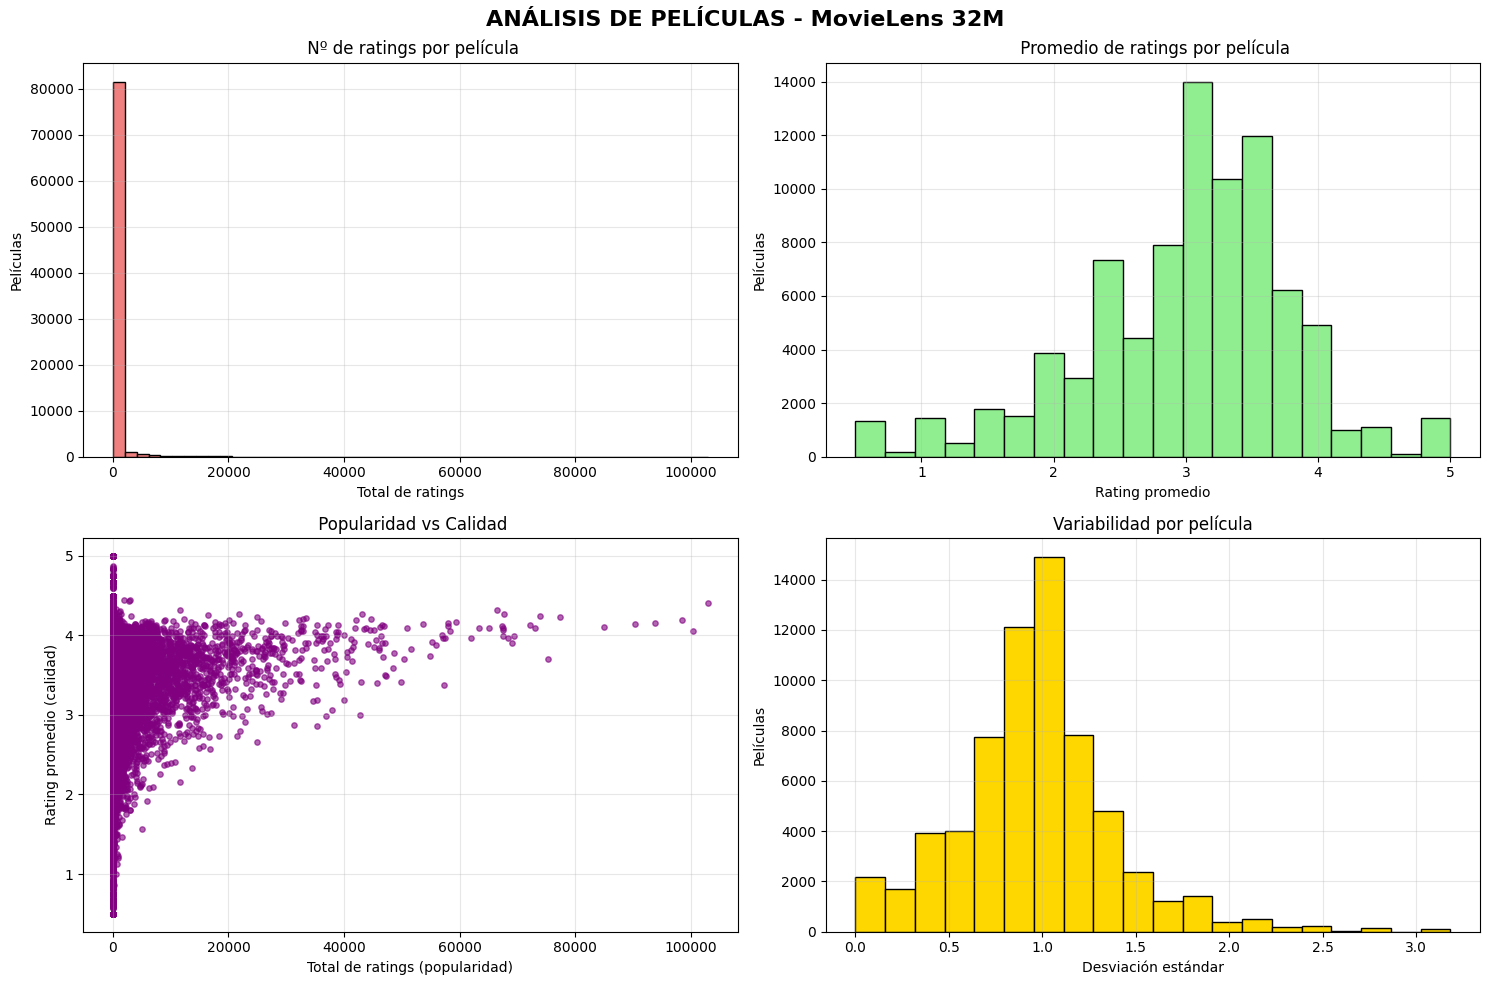

In [7]:
# Visualizaciones

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ANÁLISIS DE PELÍCULAS - MovieLens 32M', fontsize=16, fontweight='bold')

# 1. Distribución de cantidad de ratings por película
axes[0,0].hist(movie_features['total_ratings'], bins=50, color='lightcoral', edgecolor='black')
axes[0,0].set_title(' Nº de ratings por película')
axes[0,0].set_xlabel('Total de ratings')
axes[0,0].set_ylabel('Películas')
axes[0,0].grid(True, alpha=0.3)

# 2. Distribución del rating promedio por película
axes[0,1].hist(movie_features['avg_rating'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title(' Promedio de ratings por película')
axes[0,1].set_xlabel('Rating promedio')
axes[0,1].set_ylabel('Películas')
axes[0,1].grid(True, alpha=0.3)

# 3. Relación popularidad-calidad
axes[1,0].scatter(movie_features['total_ratings'], movie_features['avg_rating'], 
                  alpha=0.6, s=15, color='purple')
axes[1,0].set_title(' Popularidad vs Calidad')
axes[1,0].set_xlabel('Total de ratings (popularidad)')
axes[1,0].set_ylabel('Rating promedio (calidad)')
axes[1,0].grid(True, alpha=0.3)

# 4. Variabilidad de ratings por película
axes[1,1].hist(movie_features['std_rating'].dropna(), bins=20, color='gold', edgecolor='black')
axes[1,1].set_title('Variabilidad por película')
axes[1,1].set_xlabel('Desviación estándar')
axes[1,1].set_ylabel('Películas')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Analisis de resultado:
1. Nº Ratings por pelicula: Se observa una larga cola.
La gran mayoría de películas tienen muy pocos ratings (la barra gigante pegada al cero).
Solo unas pocas películas alcanzan decenas de miles de calificaciones.
2. Promedio de Rating por pelicula: La distribución es asimétrica positiva, centrada entre 3.0 y 4.0
Muy pocas películas con promedio menor a 2.0.
Muy pocas logran un promedio cercano a 5.0.
Esto muestra que los usuarios tienden a ser benevolentes, es raro que pongan notas muy bajas.


3. Vemos tres patrones claros:
Blockbusters: muchas calificaciones y rating promedio estable.
Regulares: muchas calificaciones pero promedio normalito (≈3.0).
Joyas ocultas: películas con pocos ratings pero promedios altos (>4).
Esto revela un trade-off: recomendar solo por promedio puede ser sesgado (pocas opiniones confiables), recomendar solo por popularidad quita descubrimiento.

Usaremos un ranking ponderado estilo IMDb, donde el rating se ajusta por el número de votos.

4. Variabilidad (std) por película.
La mayoría de películas tienen una desviación estándar entre 0.5 y 1.0,
lo que significa que los usuarios coinciden bastante en su percepción.
Algunas películas tienen variabilidad >2, lo que indica opiniones polarizantes (a unos les encanta, a otros les parece horrible).


In [8]:
#usamos un ranking ponderado estilo IMDb 

# Compute features de películas
movie_features = ratings.groupby('movieId').agg(
    v=('rating', 'count'),
    R=('rating', 'mean')
).reset_index()

In [9]:
# Calcular parámetros globales
C = ratings['rating'].mean()   # Rating promedio global
m = movie_features['v'].quantile(0.90)   # Umbral de votos: percentil 90

print(f" C (promedio global): {C:.2f}")
print(f" m (umbral mínimo de votos - percentil 90): {m}")

 C (promedio global): 3.54
 m (umbral mínimo de votos - percentil 90): 248.90000000000873


In [11]:
# Seleccionar solo películas que cumplen con el mínimo
qualified = movie_features[movie_features['v'] >= m].copy()
print("SELECCIONADAS")

SELECCIONADAS


In [12]:

# Calcular Weighted Rating (IMDb) filtrando peliculas sin suficientes votos
qualified['WR'] = (
    (qualified['v'] / (qualified['v'] + m)) * qualified['R']
    + (m / (qualified['v'] + m)) * C
)
print(qualified)

       movieId      v         R        WR
0            1  68997  3.897438  3.896154
1            2  28904  3.275758  3.278017
2            3  13134  3.139447  3.146904
3            4   2806  2.845331  2.901962
4            5  13154  3.059602  3.068530
...        ...    ...       ...       ...
82739   286905    293  3.201365  3.357085
82989   287633    366  3.480874  3.504967
83013   287699   1152  4.082899  3.986512
83159   288265    424  3.768868  3.684358
83232   288513    939  3.667732  3.641051

[8444 rows x 4 columns]


In [ ]:

# Calcular Weighted Rating (IMDb) para TODAS

movie_features['WR'] = (
    (movie_features['v'] / (movie_features['v'] + m)) * movie_features['R'] +
    (m / (movie_features['v'] + m)) * C
)
print('IMDb calculado')
print(movie_features)

IMDb calculado
       movieId      v         R        WR
0            1  68997  3.897438  3.896154
1            2  28904  3.275758  3.278017
2            3  13134  3.139447  3.146904
3            4   2806  2.845331  2.901962
4            5  13154  3.059602  3.068530
...        ...    ...       ...       ...
84427   292731      1  4.000000  3.542235
84428   292737      1  1.500000  3.532231
84429   292753      1  4.000000  3.542235
84430   292755      1  1.000000  3.530230
84431   292757      1  3.500000  3.540234

[84432 rows x 4 columns]


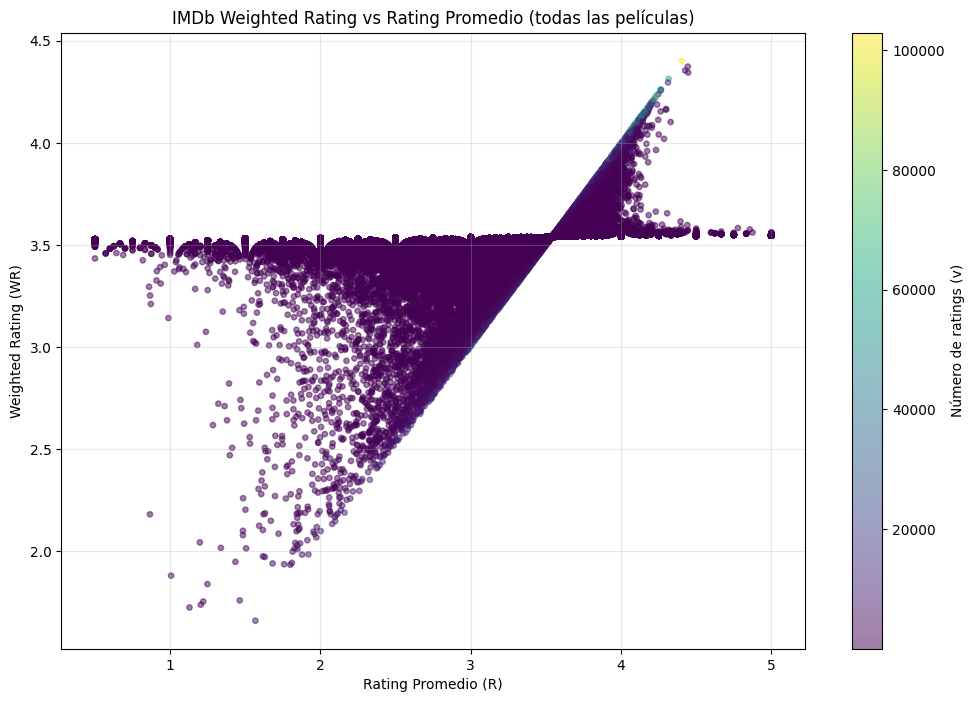

In [ ]:

#  Comparación GRÁFICA

plt.figure(figsize=(12, 8))
plt.scatter(movie_features['R'], movie_features['WR'], 
            alpha=0.5, s=15, c=movie_features['v'], cmap="viridis")
plt.colorbar(label="Número de ratings (v)")
plt.title("IMDb Weighted Rating vs Rating Promedio (todas las películas)")
plt.xlabel("Rating Promedio (R)")
plt.ylabel("Weighted Rating (WR)")
plt.grid(True, alpha=0.3)
plt.show()

Analisis de resultado:
1. Películas con pocos ratings y promedio alto (≈5.0)
En WR bajan a ~3.5 porque el sistema “no confía aún” en ellas. 
Esto evita que una película con 10 calificaciones de 5.0 aparezca injustamente en el #1.
Películas muy votadas (blockbusters)
2. Su WR casi coincide con su R porque tienen suficiente volumen (su evidencia es fuerte).
Ejemplo: una película con miles de votos y promedio 4.2 seguirá dominando arriba.
Películas mediocres (R ~2.5)
→ Mantienen un WR acorde, aunque ligeramente suavizado si tienen pocos votos.

El método IMDb es más justo y robustopermite un ranking que valora tanto calidad como popularidad.
Blockbusters ganan consistencia: se aseguran en el Top gracias a su alto número de ratings.
Joyas ocultas equilibradas: se posicionan en la media global mientras ganan más votos.
Protección contra sesgo: evita que películas poco votadas con 5.0 inflen el ranking.

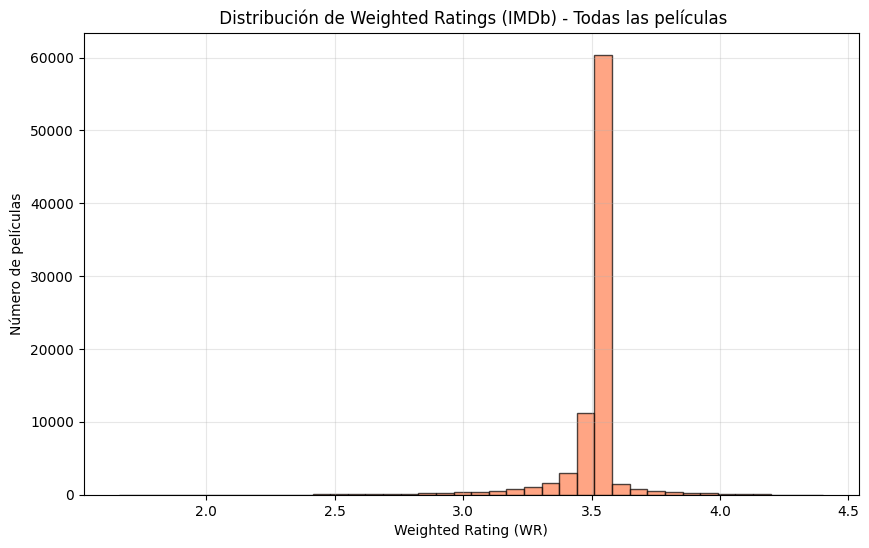

In [ ]:

# Distribución de Weighted Ratings

plt.figure(figsize=(10,6))
plt.hist(movie_features['WR'], bins=40, color="coral", edgecolor="black", alpha=0.7)
plt.title(" Distribución de Weighted Ratings (IMDb) - Todas las películas")
plt.xlabel("Weighted Rating (WR)")
plt.ylabel("Número de películas")
plt.grid(True, alpha=0.3)
plt.show()

Analisis de resultados:
1. Películas poco votadas: se “aplastan” alrededor de 3.5, sin importar si tenían 5.0 o 2.0 en promedio.
2. Películas con muchísimos votos: logran moverse significativamente hacia arriba o abajo, reflejando la opinión masiva de los usuarios.
3. Resultado: un ranking más justo y robusto que no sobrevalora películas con pocos votos.
